In [1]:
# - compatibility with Python 3
from __future__ import print_function  # print('me') instead of print 'me'
from __future__ import division  # 1/2 == 0.5, not 0

In [2]:
# - show figures inside the notebook
%matplotlib inline

In [3]:
# - import common modules
import numpy as np  # the Python array package
import matplotlib.pyplot as plt  # the Python plotting package

In [4]:
# - set gray colormap and nearest neighbor interpolation by default
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'

In [5]:
# - import numpy.linalg with a shorter name
import numpy.linalg as npl

In [6]:
# - make numpy print out values in less verbose form
np.set_printoptions(suppress=True, precision=4)

In [7]:
# - nibabel package
import nibabel as nib

In [8]:
# - our rotations module, now on the PYTHONPATH
from rotations import x_rotmat, y_rotmat, z_rotmat

## An affine normalization

For the homework reading, we used optimization to find the translations and rotations to match two functional volumes.

Now we're going to have a shot at using optimization to do an affine spatial normalization.

First - the images.  Here is a skull-stripped version of the structural image for our familiar subject 9 from OpenFMRI dataset `ds114`.

The skull-stripped version comes from the OpenFMRI dataset, but the authors have used the FSL `bet` utility to do the skull stripping:

In [9]:
# - ds114 subject 9 highres, skull stripped
subject_img = nib.load('ds114_sub009_highres_brain_222.nii')
subject_data = subject_img.get_data()
subject_data.shape

(88, 78, 128)

An example slice slicing over the third dimension:

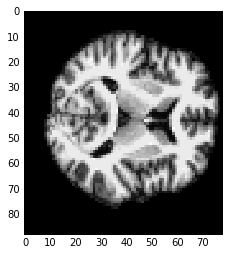

In [10]:
# - an example slice of skull-stripped structural
plt.imshow(subject_data[:, :, 80])

The MNI template we want to match to:

In [11]:
# - the MNI template - also skull stripped
template_img = nib.load('mni_icbm152_t1_tal_nlin_asym_09a_masked_222.nii')
template_data = template_img.get_data()
template_data.shape

(99, 117, 95)

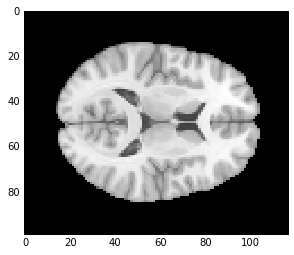

In [12]:
# - an example slice over the third dimension of the template
plt.imshow(template_data[:, :, 42])

We have a current mapping from the voxels in the *template* image to the voxels in the *subject* image, using the image affines.  What is that mapping (`template_vox2subject_vox`)?

In [13]:
# Get affine mapping from template voxels to subject voxels
template_vox2subject_vox = npl.inv(subject_img.affine).dot(template_img.affine)
template_vox2subject_vox

array([[ -1.    ,   0.    ,   0.    ,  90.3506],
       [ -0.    ,   0.7691,   0.    , -18.22  ],
       [ -0.    ,  -0.    ,   1.    ,  50.6663],
       [  0.    ,   0.    ,   0.    ,   1.    ]])

Break up this affine into the 3x3 `mat` component and length 3 `vec` translation component.  We'll need to use those in `affine_transform`:

In [14]:
# Break up `template_vox2subject_vox` into 3x3 `mat` and length 3 `vec`
mat, vec = nib.affines.to_matvec(template_vox2subject_vox)
mat, vec

(array([[-1.    ,  0.    ,  0.    ],
        [-0.    ,  0.7691,  0.    ],
        [-0.    , -0.    ,  1.    ]]), array([ 90.3506, -18.22  ,  50.6663]))

Use `scipy.ndimage.affine_transform` to make a new version of the subject image, resampled into the array size / shape of the template:

In [15]:
# Use affine_transform to make a copy of the subject image
# resampled into the array dimensions of the template image
# Call this resampled copy `subject_resampled`
# (we are going to use this array later).
# Use order=1 for the resampling (it is quicker)
from scipy.ndimage import affine_transform
subject_resampled = affine_transform(subject_data, mat, vec,
                                     output_shape=template_data.shape,
                                     order=1)

Plot a slice from the resampled subject data next to the matching slice from the template using `subplots`:

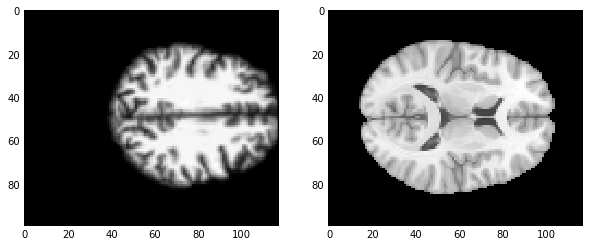

In [16]:
# Plot slice from resampled subject data next to slice from template data
fig, axes = plt.subplots(1, 2, figsize=(10, 15))
axes[0].imshow(subject_resampled[:, :, 42])
axes[1].imshow(template_data[:, :, 42])

Now we are going to try and do an affine match between these two images, using optimization.

We are going to need a *cost function*.

Remember, this takes the set of parameters we are using to transform the data, and returns a value that should be low when the images are well matched.

The value our cost function returns, is a mismatch metric.

I suggest you use the correlation mismatch function for the metric.  Here is an implementation of the formula for Pearson's product-moment correlation coefficient from [wikipedia](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient):

$$
r = r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}
$$

where $\bar{x}$ is the mean:

$$
\bar{x} = \frac{1}{n} \sum ^n _{i=1} x_i
$$

The correlation makes sense here, because both the subject scan and the template are T1-weighted images, meaning that we expect gray matter to be gray, white matter to be white, and CSF to be black.  So, when the images are well-matched, the signal in one image should correlate highly with the signal from matching voxels in the other.

In [17]:
# - the negative correlation mismatch metric
def correl_mismatch(x, y):
    """ Negative correlation between the two images, flattened to 1D """
    # Correlation
    x_mean0 = x.ravel() - x.mean()
    y_mean0 = y.ravel() - y.mean()
    corr_top = x_mean0.dot(y_mean0)
    corr_bottom = (np.sqrt(x_mean0.dot(x_mean0)) *
                   np.sqrt(y_mean0.dot(y_mean0)))
    return -corr_top / corr_bottom

Let's check this gives the same answer as the standard numpy function:

In [18]:
# - check numpy agrees with our negative correlation calculation
x = np.random.normal(size=(100,))
y = np.random.normal(size=(100,))
assert np.allclose(correl_mismatch(x, y), -np.corrcoef(x, y)[0, 1])

Now we need a function that will transform the subject image, given a set of transformation parameters.

Let's use these transformation parameters:

* `x_t` : translation in x
* `y_t` : translation in y
* `z_t` : translation in z
* `x_r` : rotation around x axis
* `y_r` : rotation around y axis
* `z_r` : rotation around z axis
* `x_z` : zoom (scaling) in x
* `y_z` : zoom (scaling) in y
* `z_z` : zoom (scaling) in z

Say `vol_arr` is the image that we will transform;

Our function then returns a copy of `vol_arr` with those tranformations applied.

Let's also say that these transformations are in millimeters.

That means we are going to make these transformations into a new 4x4 affine `P`, and compose it with the template and subject affines:

* First - apply `template_vox2mm` mapping to map to millimeters;
* Next - apply `P` affine made up of our transformations above;
* Next - apply `mm2subject_vox`
* Call the result `Q`.

Finally, we want to apply the transformations in `Q` to make a resampled copy of the subject image.

Our first task is to take the 9 parameters above, and return the affine matrix `P`.

This function will look something like this:

```
def params2affine(params):
    # Unpack the parameter vector to individual parameters
    x_t, y_t, z_t, x_r, y_r, z_r, x_z, y_z, z_z = params
    # Matrix for zooms?
    # Matrix for rotations?
    # Vector for translations?
    # Build into affine
```

Hint: remember you have already imported `x_rotmat` etc from our `rotations` module.

In [19]:
# Make params2affine function
# * accepts params vector
# * builds matrix for zooms
# * builds atrix for rotations
# * builds vector for translations
# * compile into affine and return
def params2affine(params):
    # Unpack the parameter vector to individual parameters
    x_t, y_t, z_t, x_r, y_r, z_r, x_z, y_z, z_z = params
    # Matrix for zooms
    zooms = np.diag([x_z, y_z, z_z])
    # Matrix for rotations
    x_rot = x_rotmat(x_r)
    y_rot = y_rotmat(y_r)
    z_rot = z_rotmat(z_r)
    # Vector for translations
    vec = [x_t, y_t, z_t]
    # Build into affine
    mat = x_rot.dot(y_rot).dot(z_rot).dot(zooms)
    return nib.affines.from_matvec(mat, vec)

In [20]:
# - some checks that the function does the right thing
# Identity params gives identity affine
assert np.allclose(params2affine([0, 0, 0, 0, 0, 0, 1, 1, 1]), np.eye(4))
# Some zooms
assert np.allclose(params2affine([0, 0, 0, 0, 0, 0, 2, 3, 4]),
                   np.diag([2, 3, 4, 1]))
# Some translations
assert np.allclose(params2affine([0, 0, 0, 0, 0, 0, 2, 3, 4]),
                   np.diag([2, 3, 4, 1]))
# Some rotations
assert np.allclose(params2affine([0, 0, 0, 0, 0, 0.2, 1, 1, 1]),
                   [[np.cos(0.2), -np.sin(0.2), 0, 0],
                    [np.sin(0.2), np.cos(0.2), 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    ])
assert np.allclose(params2affine([0, 0, 0, 0, 0, 0.2, 1, 1, 1]),
                   [[np.cos(0.2), -np.sin(0.2), 0, 0],
                    [np.sin(0.2), np.cos(0.2), 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    ])
assert np.allclose(params2affine([0, 0, 0, 0, -0.1, 0, 1, 1, 1]),
                   [[np.cos(-0.1), 0, np.sin(-0.1), 0],
                    [0, 1, 0, 0],
                    [-np.sin(-0.1), 0, np.cos(-0.1), 0],
                    [0, 0, 0, 1],
                    ])
assert np.allclose(params2affine([0, 0, 0, 0.3, 0, 0, 1, 1, 1]),
                   [[1, 0, 0, 0],
                    [0, np.cos(0.3), -np.sin(0.3), 0],
                    [0, np.sin(0.3), np.cos(0.3), 0],
                    [0, 0, 0, 1],
                    ])
# Translation
assert np.allclose(params2affine([11, 12, 13, 0, 0, 0, 1, 1, 1]),
                   [[1, 0, 0, 11],
                    [0, 1, 0, 12],
                    [0, 0, 1, 13],
                    [0, 0, 0, 1]
                    ])

Now we know how to make our affine `P`, we can make our cost function.

The cost function should accept the same vector of parameters as `params2affine`, then:

* generate `P`;
* compose template_vox2mm, then P then mm2subject_vox to give `Q`;
* resample the subject data using the matrix and vector from `Q` (use order=1 resampling - it is quicker);
* return the mismatch metric for the resampled image and template.

We can pick up the subject data and template data from the global namespace.

In [21]:
# Make a cost function called `cost_function` that will:
# * accept the vector of parameters containing x_t ... z_z
# * generate `P`;
# * compose template_vox2mm, then P then mm2subject_vox to give `Q`;
# * resample the subject data using the matrix and vector from `Q`.
#   Use `order=1` for the resampling - otherwise it will be slow.
# * return the mismatch metric for the resampled image and template.
def cost_function(params):
    P = params2affine(params)
    Q = npl.inv(subject_img.affine).dot(P).dot(template_img.affine)
    mat,  vec = nib.affines.to_matvec(Q)
    resampled = affine_transform(subject_data, mat, vec,
                                 output_shape=template_img.shape,
                                 order=1)
    return correl_mismatch(template_data, resampled)

In [22]:
# - check the cost function returns the previous value if params
# say to do no transformation
current = correl_mismatch(subject_resampled, template_data)
redone = cost_function([0, 0, 0, 0, 0, 0, 1, 1, 1])
assert np.allclose(current, redone)

Now we are ready to optimize.  We are going to need at least one of the cost functions from `scipy.optimize`.

`fmin_powell` is a good place to start:

In [23]:
# - get fmin_powell
from scipy.optimize import fmin_powell

Let's define a callback so we can see what `fmin_powell` is doing:

In [24]:
# - a callback we will pass to the fmin_powell function
def my_callback(params):
   print("Trying parameters " + str(params))

Now call `fmin_powell` with a starting guess for the parameters.  Remember to pass the callback with ``callback=my_callback``.

This is going to take a crazy long time.  Maybe 10 minutes.

In [25]:
# Call optimizing function and collect best estimates for rotations
# Collect best estimates in `best_params` variable
best_params = fmin_powell(cost_function, [0, 0, 0, 0, 0, 0, 1, 1, 1],
                          callback=my_callback)
best_params

Trying parameters [ -0.417   41.5029 -22.1551   0.0015  -0.0017   0.0033   0.8909   0.9572
   0.9033]
Trying parameters [ -1.7615  39.1924 -19.4564   0.0246  -0.0098   0.0222   0.9218   0.9484
   0.8877]
Trying parameters [ -2.035   38.6871 -18.9906   0.0287  -0.0075   0.028    0.9215   0.9484
   0.8877]
Trying parameters [ -2.0349  38.6679 -18.986    0.0287  -0.0075   0.028    0.9215   0.9484
   0.8877]
Optimization terminated successfully.
         Current function value: -0.925598
         Iterations: 4
         Function evaluations: 737


array([ -2.0349,  38.6679, -18.986 ,   0.0287,  -0.0075,   0.028 ,
         0.9215,   0.9484,   0.8877])

Finally, use these parameters to:

* compile the P affine from the optimized parameters;
* compile the Q affine from the image affines and P;
* resample the subject image using the matrix and vector from this Q affine.

In [26]:
# * compile the P affine from the optimized parameters;
# * compile the Q affine from the image affines and P;
# * resample the subject image using the matrix and vector from the Q affine.
P = params2affine(best_params)
Q = npl.inv(subject_img.affine).dot(P).dot(template_img.affine)
mat, vec = nib.affines.to_matvec(Q)
best_subject_data = affine_transform(subject_data, mat, vec,
                                     output_shape=template_img.shape)

Now you can look at the template and the resampled affine-normalized image side by side, using `subplots`:

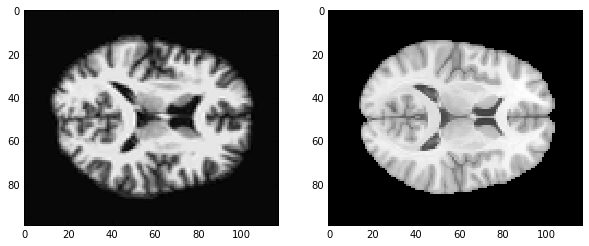

In [27]:
# show example slice from template and normalized image
fig, axes = plt.subplots(1, 2, figsize=(10, 15))
axes[0].imshow(best_subject_data[:, :, 42])
axes[1].imshow(template_data[:, :, 42])